<h1>Prova 2 - Introdução à Ciência dos Dados</h1>
<h3>Daniel Freitas Martins - 2304</h3>

In [1]:
import time
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm as class_svm
from sklearn import  preprocessing
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.model_selection import train_test_split
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
def lerCSV(caminho_arquivo, header):
    return pd.read_csv(caminho_arquivo, index_col=False, header=header, squeeze=True)

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
   
    if not title:
        if normalize:
            title = 'Matriz de Confusão normalizada'
        else:
            title = 'Matriz de Confusão NÃO normalizada'

    # calcula  a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão normalizada")
    else:
        print('Matriz de Confusão NÃO normalizada')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ...criando os labels
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Entrada',
           xlabel='Saida')

    # rotacionando os labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Percorrendo sobre os dados e criando as anotações de texto
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

<h2>Lendo Dados-Prova02.csv, que contém informações de contratos de planos de assinatura de uma empresa de telecomunicações</h2>

In [4]:
df = lerCSV("Dados-Prova02.csv", header=0)
df.head(3)

id-usuario    sexo  is-idoso has-parceiro has-dependentes  \
0  7590-VHVEG  Female         0          Yes              No   
1  5575-GNVDE    Male         0           No              No   
2  3668-QPYBK    Male         0           No              No   

   tempo-contrato-meses has-servico-telefone has-multiplas-linhas  \
0                     1                   No                   No   
1                    34                  Yes                   No   
2                     2                  Yes                   No   

  servico-internet has-seguranca-online has-backup-online  \
0              DSL                   No               Yes   
1              DSL                  Yes                No   
2              DSL                  Yes               Yes   

  has-protecao-dispositivo has-suporte-tecnico has-streaming-tv  \
0                       No                  No               No   
1                      Yes                  No               No   
2                       No                  No               No   

  has-streaming-filmes   tipo-contrato has-pagamento-online  metodo-pagamento  \
0                   No  Month-to-month                  Yes  Electronic check   
1                   No        One year                   No      Mailed check   
2                   No  Month-to-month                  Yes      Mailed check   

   valor-mensal Churn  
0         29.85    No  
1         56.95    No  
2         53.85   Yes

In [5]:
len(df)

7043

<h2>1) Faça uma análise exploratória dos dados, para conhecer melhor sobre os mesmos, seus
tipos, suas características, suas correlações, dentre outras informações que julgar necessárias e
importantes.</h2>

In [6]:
def imprimirRelacionamentosChurn(df):
    qtd_registros = df['Churn'].count()
    qtd_cancelamentos = df[df['Churn'] == 1]['Churn'].count()
    qtd_ativos = df[df['Churn'] == 0]['Churn'].count()
    p_cancelamentos = (qtd_cancelamentos/qtd_registros*100)
    p_ativos = (qtd_ativos/qtd_registros*100)
    print('  Quantidade de registros:', qtd_registros)
    print('  Número de cancelamento de contratos:', qtd_cancelamentos)
    print('  Número de contratos não cancelados:', qtd_ativos)
    print('  Porcentagem de contratos cancelados: %.2f%%' % p_cancelamentos)
    print('  Porcentagem de contratos não cancelados: %.2f%%' % p_ativos)
    return p_cancelamentos, p_ativos

In [7]:
def imprimirRelacionamentosChurnAux(df_convertido, coluna, titulo_0='Valor = 1', titulo_1='Valor = 0'):
    x = coluna
    df_aux = df_convertido[[x, 'Churn']]

    print('----- Atributo:', coluna, '-----')
    ax = sns.countplot(data=df_aux, x=x, hue='Churn')
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', rotation=45, xytext=(0, 20),
                 textcoords='offset points')
    
    print(titulo_0)
    p_c1, p_a1 = imprimirRelacionamentosChurn(df_aux[df_aux[x]==0])
    print('\n'+titulo_1)
    p_c2, p_a2 = imprimirRelacionamentosChurn(df_aux[df_aux[x]==1])
    
    print('\nDiferença das porcentagens de contratos cancelados: %.2f%%' % (abs(p_c1 - p_c2)))
    print('Diferença das porcentagens de contratos não cancelados: %.2f%%' % (abs(p_a1 - p_a2)))
    plt.show()
    

In [8]:
print(*df.columns, sep=', ')

id-usuario, sexo, is-idoso, has-parceiro, has-dependentes, tempo-contrato-meses, has-servico-telefone, has-multiplas-linhas, servico-internet, has-seguranca-online, has-backup-online, has-protecao-dispositivo, has-suporte-tecnico, has-streaming-tv, has-streaming-filmes, tipo-contrato, has-pagamento-online, metodo-pagamento, valor-mensal, Churn


Verificando os tipos de dados dos atributos.

In [9]:
print(df.dtypes)

id-usuario                   object
sexo                         object
is-idoso                      int64
has-parceiro                 object
has-dependentes              object
tempo-contrato-meses          int64
has-servico-telefone         object
has-multiplas-linhas         object
servico-internet             object
has-seguranca-online         object
has-backup-online            object
has-protecao-dispositivo     object
has-suporte-tecnico          object
has-streaming-tv             object
has-streaming-filmes         object
tipo-contrato                object
has-pagamento-online         object
metodo-pagamento             object
valor-mensal                float64
Churn                        object
dtype: object


Verificando se existem dados nulos.

In [10]:
print('Quantidade de registros nulos:', df.isnull().sum().max())
for col in df.columns:
    print(col, sum(pd.isnull(df[col])))

Quantidade de registros nulos: 0
id-usuario 0
sexo 0
is-idoso 0
has-parceiro 0
has-dependentes 0
tempo-contrato-meses 0
has-servico-telefone 0
has-multiplas-linhas 0
servico-internet 0
has-seguranca-online 0
has-backup-online 0
has-protecao-dispositivo 0
has-suporte-tecnico 0
has-streaming-tv 0
has-streaming-filmes 0
tipo-contrato 0
has-pagamento-online 0
metodo-pagamento 0
valor-mensal 0
Churn 0


Verificando os valores únicos de cada coluna.

In [11]:
for col in df.columns:
    print(col, df[col].unique())

id-usuario ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
sexo ['Female' 'Male']
is-idoso [0 1]
has-parceiro ['Yes' 'No']
has-dependentes ['No' 'Yes']
tempo-contrato-meses [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
has-servico-telefone ['No' 'Yes']
has-multiplas-linhas ['No' 'Yes']
servico-internet ['DSL' 'Fiber optic' 'No']
has-seguranca-online ['No' 'Yes']
has-backup-online ['Yes' 'No']
has-protecao-dispositivo ['No' 'Yes']
has-suporte-tecnico ['No' 'Yes']
has-streaming-tv ['No' 'Yes']
has-streaming-filmes ['No' 'Yes']
tipo-contrato ['Month-to-month' 'One year' 'Two year']
has-pagamento-online ['Yes' 'No']
metodo-pagamento ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
valor-mensal [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
Ch

Convertendo algumas colunas para tipos numéricos: Yes = 1; No = 0 e também Male = 1, Female = 0

In [12]:
df_convertido = df.copy()
df_convertido['sexo'] = [1 if x == 'Male' else 0 for x in df_convertido['sexo']]
cols_conversao = ['has-parceiro', 'has-dependentes', 'has-servico-telefone', 'has-multiplas-linhas',
                      'has-seguranca-online', 'has-backup-online', 'has-protecao-dispositivo',
                      'has-suporte-tecnico', 'has-streaming-tv', 'has-streaming-filmes',
                      'has-pagamento-online', 'Churn']

for col in cols_conversao:
    df_convertido[col] = [1 if x == 'Yes' else 0 for x in df_convertido[col]]
    
#df_convertido['tipo-contrato'] = [0 if x == 'Month-to-month' else 1 if x == 'One year' else 2]
    
df_convertido.head(3)

id-usuario  sexo  is-idoso  has-parceiro  has-dependentes  \
0  7590-VHVEG     0         0             1                0   
1  5575-GNVDE     1         0             0                0   
2  3668-QPYBK     1         0             0                0   

   tempo-contrato-meses  has-servico-telefone  has-multiplas-linhas  \
0                     1                     0                     0   
1                    34                     1                     0   
2                     2                     1                     0   

  servico-internet  has-seguranca-online  has-backup-online  \
0              DSL                     0                  1   
1              DSL                     1                  0   
2              DSL                     1                  1   

   has-protecao-dispositivo  has-suporte-tecnico  has-streaming-tv  \
0                         0                    0                 0   
1                         1                    0                 0   
2                         0                    0                 0   

   has-streaming-filmes   tipo-contrato  has-pagamento-online  \
0                     0  Month-to-month                     1   
1                     0        One year                     0   
2                     0  Month-to-month                     1   

   metodo-pagamento  valor-mensal  Churn  
0  Electronic check         29.85      0  
1      Mailed check         56.95      0  
2      Mailed check         53.85      1

In [13]:
print(df_convertido.dtypes)

id-usuario                   object
sexo                          int64
is-idoso                      int64
has-parceiro                  int64
has-dependentes               int64
tempo-contrato-meses          int64
has-servico-telefone          int64
has-multiplas-linhas          int64
servico-internet             object
has-seguranca-online          int64
has-backup-online             int64
has-protecao-dispositivo      int64
has-suporte-tecnico           int64
has-streaming-tv              int64
has-streaming-filmes          int64
tipo-contrato                object
has-pagamento-online          int64
metodo-pagamento             object
valor-mensal                float64
Churn                         int64
dtype: object


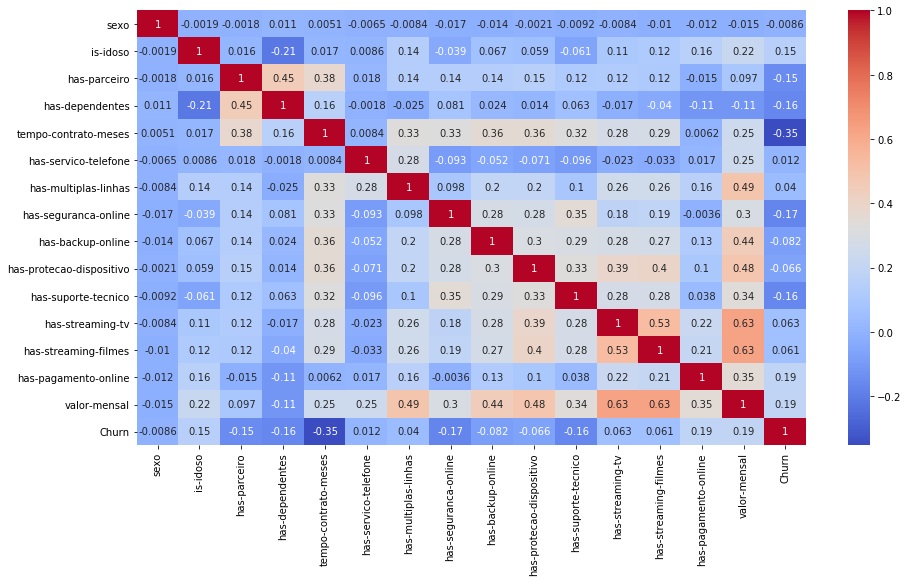

In [14]:
#Usando a correlação de Pearson
plt.figure(figsize=(15,8))
corr = df_convertido.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Imprimindo pairplots. O primeiro consiste dos atributos com maiores correlações apresentadas e o segundo consiste de outros atributos também interessantes para a análise.

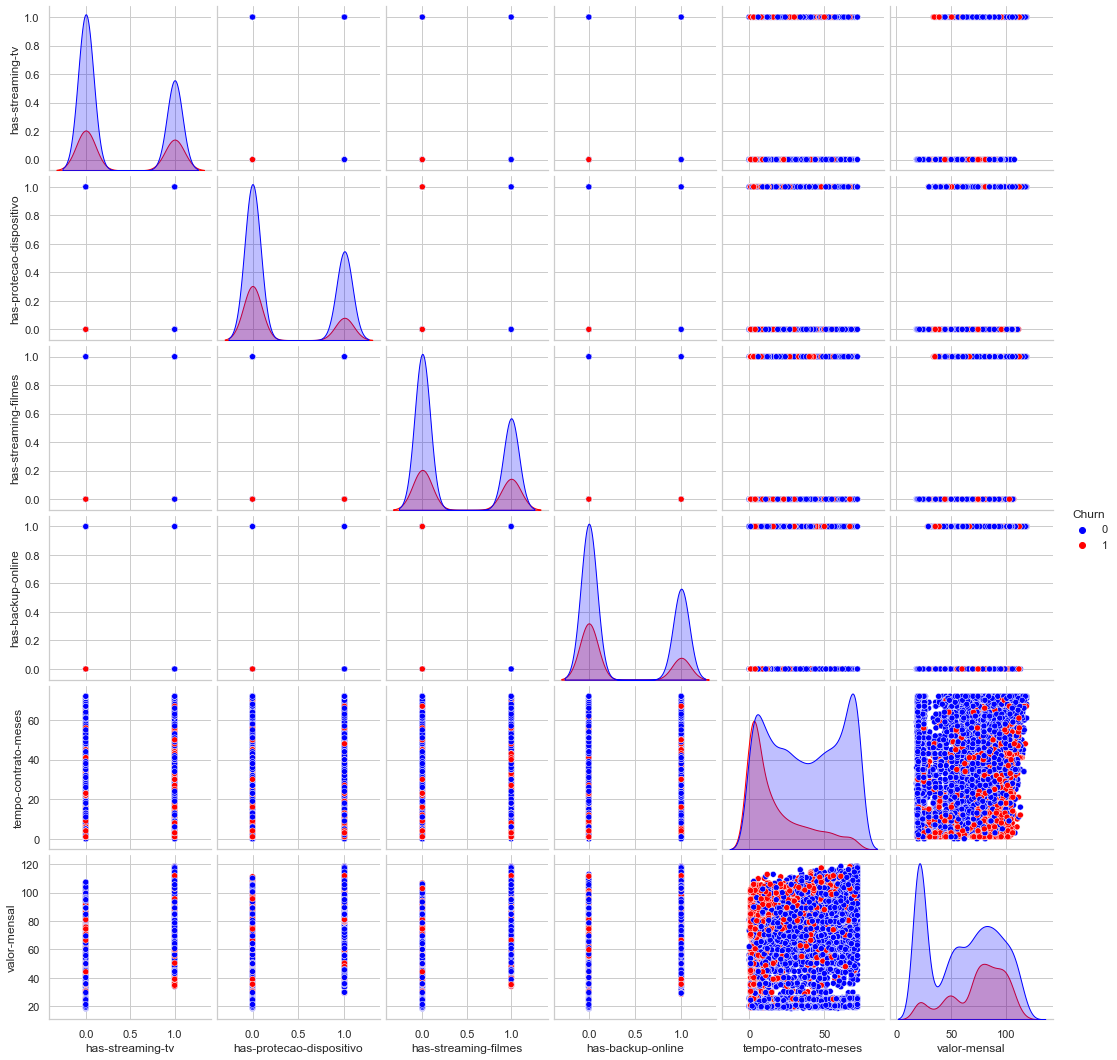

In [15]:
cols = ['Churn', 'has-streaming-tv', 'has-protecao-dispositivo', 'has-streaming-filmes', 'has-backup-online',
                            'tempo-contrato-meses', 'valor-mensal']
sns.set(style='whitegrid')
sns.pairplot(df_convertido[cols], hue='Churn', palette=['blue', 'red'])
plt.show()

Estudando maiores detalhes a respeito de correlações de alguns atributos binários.

----- Atributo: has-streaming-tv -----
Valor = 1
  Quantidade de registros: 4336
  Número de cancelamento de contratos: 1055
  Número de contratos não cancelados: 3281
  Porcentagem de contratos cancelados: 24.33%
  Porcentagem de contratos não cancelados: 75.67%

Valor = 0
  Quantidade de registros: 2707
  Número de cancelamento de contratos: 814
  Número de contratos não cancelados: 1893
  Porcentagem de contratos cancelados: 30.07%
  Porcentagem de contratos não cancelados: 69.93%

Diferença das porcentagens de contratos cancelados: 5.74%
Diferença das porcentagens de contratos não cancelados: 5.74%


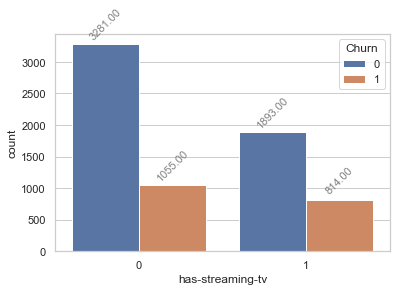

----- Atributo: has-protecao-dispositivo -----
Valor = 1
  Quantidade de registros: 4621
  Número de cancelamento de contratos: 1324
  Número de contratos não cancelados: 3297
  Porcentagem de contratos cancelados: 28.65%
  Porcentagem de contratos não cancelados: 71.35%

Valor = 0
  Quantidade de registros: 2422
  Número de cancelamento de contratos: 545
  Número de contratos não cancelados: 1877
  Porcentagem de contratos cancelados: 22.50%
  Porcentagem de contratos não cancelados: 77.50%

Diferença das porcentagens de contratos cancelados: 6.15%
Diferença das porcentagens de contratos não cancelados: 6.15%


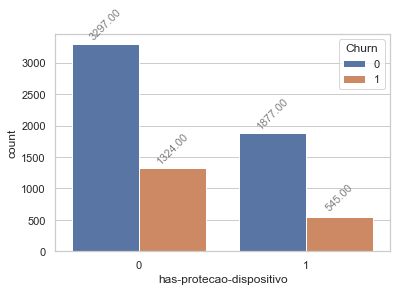

----- Atributo: has-streaming-filmes -----
Valor = 1
  Quantidade de registros: 4311
  Número de cancelamento de contratos: 1051
  Número de contratos não cancelados: 3260
  Porcentagem de contratos cancelados: 24.38%
  Porcentagem de contratos não cancelados: 75.62%

Valor = 0
  Quantidade de registros: 2732
  Número de cancelamento de contratos: 818
  Número de contratos não cancelados: 1914
  Porcentagem de contratos cancelados: 29.94%
  Porcentagem de contratos não cancelados: 70.06%

Diferença das porcentagens de contratos cancelados: 5.56%
Diferença das porcentagens de contratos não cancelados: 5.56%


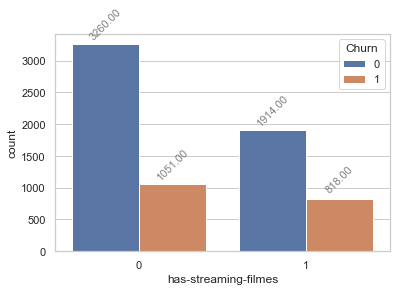

----- Atributo: has-backup-online -----
Valor = 1
  Quantidade de registros: 4614
  Número de cancelamento de contratos: 1346
  Número de contratos não cancelados: 3268
  Porcentagem de contratos cancelados: 29.17%
  Porcentagem de contratos não cancelados: 70.83%

Valor = 0
  Quantidade de registros: 2429
  Número de cancelamento de contratos: 523
  Número de contratos não cancelados: 1906
  Porcentagem de contratos cancelados: 21.53%
  Porcentagem de contratos não cancelados: 78.47%

Diferença das porcentagens de contratos cancelados: 7.64%
Diferença das porcentagens de contratos não cancelados: 7.64%


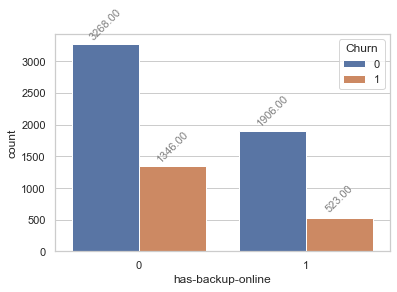

In [16]:
for col in df_convertido[cols].drop(['Churn', 'tempo-contrato-meses', 'valor-mensal'], axis=1):
    imprimirRelacionamentosChurnAux(df_convertido, col)

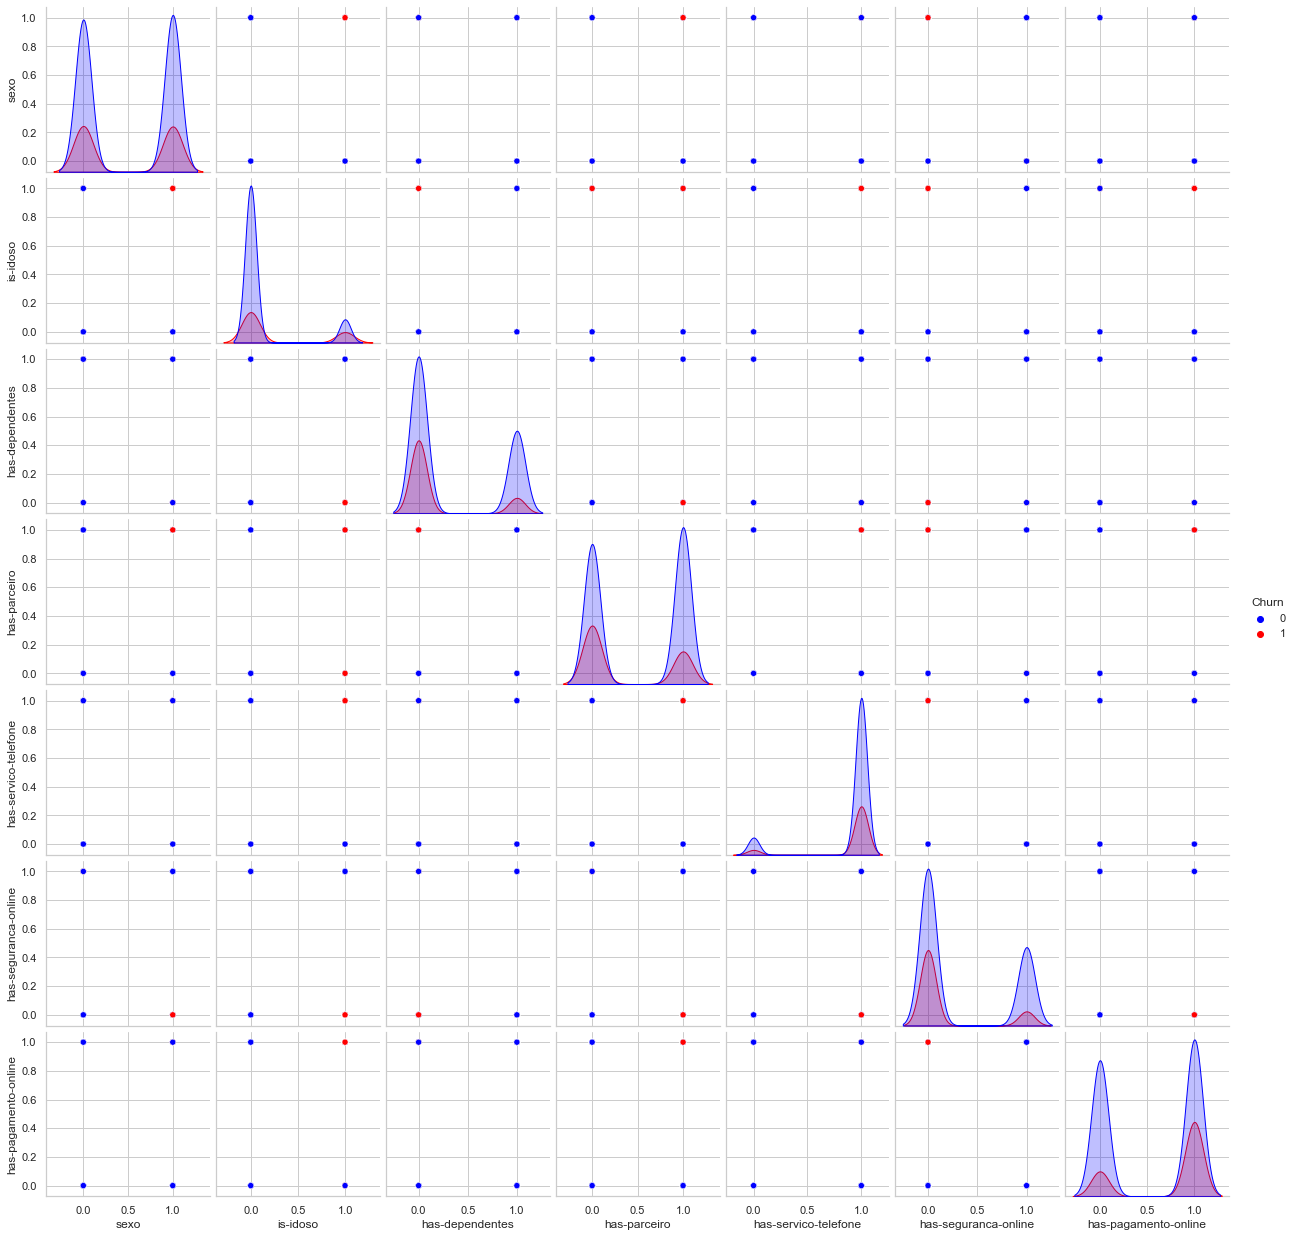

In [17]:
cols = ['Churn', 'sexo', 'is-idoso', 'has-dependentes', 'has-parceiro',
                           'has-servico-telefone', 'has-seguranca-online', 'has-pagamento-online']
sns.set(style='whitegrid')
sns.pairplot(df_convertido[cols], hue='Churn', palette=['blue', 'red'])
plt.show()

----- Atributo: sexo -----
Valor = 1
  Quantidade de registros: 3488
  Número de cancelamento de contratos: 939
  Número de contratos não cancelados: 2549
  Porcentagem de contratos cancelados: 26.92%
  Porcentagem de contratos não cancelados: 73.08%

Valor = 0
  Quantidade de registros: 3555
  Número de cancelamento de contratos: 930
  Número de contratos não cancelados: 2625
  Porcentagem de contratos cancelados: 26.16%
  Porcentagem de contratos não cancelados: 73.84%

Diferença das porcentagens de contratos cancelados: 0.76%
Diferença das porcentagens de contratos não cancelados: 0.76%


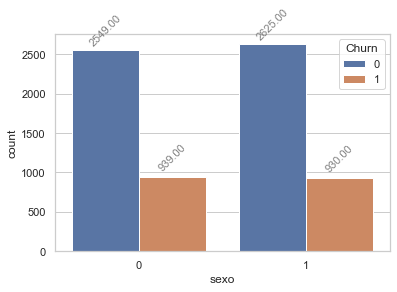

----- Atributo: is-idoso -----
Valor = 1
  Quantidade de registros: 5901
  Número de cancelamento de contratos: 1393
  Número de contratos não cancelados: 4508
  Porcentagem de contratos cancelados: 23.61%
  Porcentagem de contratos não cancelados: 76.39%

Valor = 0
  Quantidade de registros: 1142
  Número de cancelamento de contratos: 476
  Número de contratos não cancelados: 666
  Porcentagem de contratos cancelados: 41.68%
  Porcentagem de contratos não cancelados: 58.32%

Diferença das porcentagens de contratos cancelados: 18.08%
Diferença das porcentagens de contratos não cancelados: 18.08%


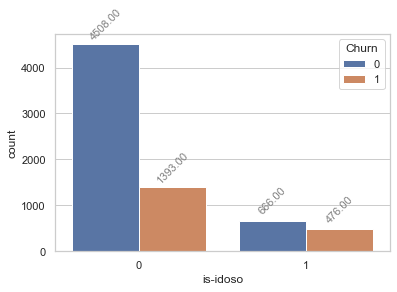

----- Atributo: has-dependentes -----
Valor = 1
  Quantidade de registros: 4933
  Número de cancelamento de contratos: 1543
  Número de contratos não cancelados: 3390
  Porcentagem de contratos cancelados: 31.28%
  Porcentagem de contratos não cancelados: 68.72%

Valor = 0
  Quantidade de registros: 2110
  Número de cancelamento de contratos: 326
  Número de contratos não cancelados: 1784
  Porcentagem de contratos cancelados: 15.45%
  Porcentagem de contratos não cancelados: 84.55%

Diferença das porcentagens de contratos cancelados: 15.83%
Diferença das porcentagens de contratos não cancelados: 15.83%


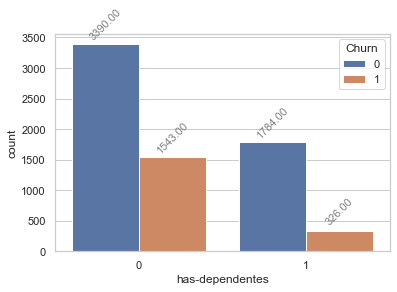

----- Atributo: has-parceiro -----
Valor = 1
  Quantidade de registros: 3641
  Número de cancelamento de contratos: 1200
  Número de contratos não cancelados: 2441
  Porcentagem de contratos cancelados: 32.96%
  Porcentagem de contratos não cancelados: 67.04%

Valor = 0
  Quantidade de registros: 3402
  Número de cancelamento de contratos: 669
  Número de contratos não cancelados: 2733
  Porcentagem de contratos cancelados: 19.66%
  Porcentagem de contratos não cancelados: 80.34%

Diferença das porcentagens de contratos cancelados: 13.29%
Diferença das porcentagens de contratos não cancelados: 13.29%


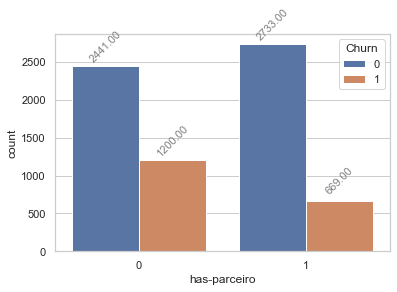

----- Atributo: has-servico-telefone -----
Valor = 1
  Quantidade de registros: 682
  Número de cancelamento de contratos: 170
  Número de contratos não cancelados: 512
  Porcentagem de contratos cancelados: 24.93%
  Porcentagem de contratos não cancelados: 75.07%

Valor = 0
  Quantidade de registros: 6361
  Número de cancelamento de contratos: 1699
  Número de contratos não cancelados: 4662
  Porcentagem de contratos cancelados: 26.71%
  Porcentagem de contratos não cancelados: 73.29%

Diferença das porcentagens de contratos cancelados: 1.78%
Diferença das porcentagens de contratos não cancelados: 1.78%


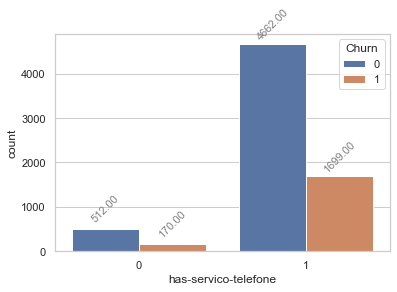

----- Atributo: has-seguranca-online -----
Valor = 1
  Quantidade de registros: 5024
  Número de cancelamento de contratos: 1574
  Número de contratos não cancelados: 3450
  Porcentagem de contratos cancelados: 31.33%
  Porcentagem de contratos não cancelados: 68.67%

Valor = 0
  Quantidade de registros: 2019
  Número de cancelamento de contratos: 295
  Número de contratos não cancelados: 1724
  Porcentagem de contratos cancelados: 14.61%
  Porcentagem de contratos não cancelados: 85.39%

Diferença das porcentagens de contratos cancelados: 16.72%
Diferença das porcentagens de contratos não cancelados: 16.72%


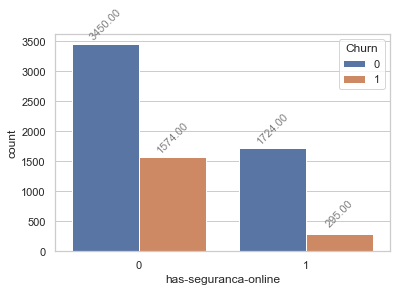

----- Atributo: has-pagamento-online -----
Valor = 1
  Quantidade de registros: 2872
  Número de cancelamento de contratos: 469
  Número de contratos não cancelados: 2403
  Porcentagem de contratos cancelados: 16.33%
  Porcentagem de contratos não cancelados: 83.67%

Valor = 0
  Quantidade de registros: 4171
  Número de cancelamento de contratos: 1400
  Número de contratos não cancelados: 2771
  Porcentagem de contratos cancelados: 33.57%
  Porcentagem de contratos não cancelados: 66.43%

Diferença das porcentagens de contratos cancelados: 17.24%
Diferença das porcentagens de contratos não cancelados: 17.24%


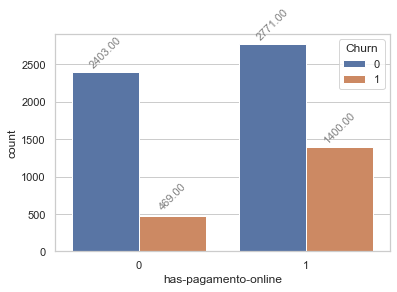

In [18]:
for col in df_convertido[cols].drop(['Churn'], axis=1):
    imprimirRelacionamentosChurnAux(df_convertido, col)

Verificando se existe correlação entre o método de pagamento e o atributo Churn.
(metodo-pagamento ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'])

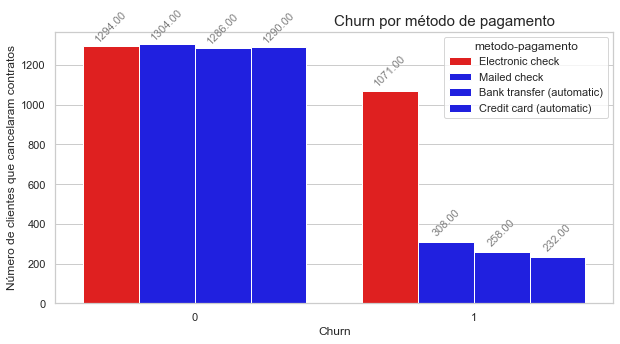

In [19]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Churn", hue="metodo-pagamento", data=df_convertido, palette=['red', 'blue', 'blue', 'blue']);
ax.set_ylabel('Número de clientes que cancelaram contratos', fontsize = 12)
ax.set_xlabel('Churn', fontsize = 12)
# alinhando título para não prejudicar visualização dos valores
ax.set_title('Churn por método de pagamento', fontsize=15, horizontalalignment='left')
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', fontsize=11, color='gray', rotation=45, xytext=(0, 20),
        textcoords='offset points')
plt.show()

Observando-se o pairplot, a matriz de correlação e as outras informações mostradas acima, podemos observar o seguinte:
<ol>
    <li>As pessoas do sexo masculino e as pessoas do sexo feminino tendem a ter o mesmo comportamento em relação ao cancelamento de contratos (Churn). Este resultado é bastante curioso e indica que o sexo da pessoa não determina se ela tem maiores chances de cancelar ou não um contrato.</li>
    <li>As pessoas mais jovens tendem a cancelar menos os contratos do que as pessoas mais velhas. Dos idosos, aproximadamente 42% cancelaram os contratos, enquanto que, dos jovens, aproximadamente 24% cancelaram os contratos. Em se tratando de uma diferença de 20%, O atributo is-idoso pode ter alguma relação com o atributo Churn.</li>
    <li>Os atributos que possuem maiores correlação com o atributo Churn são: is-idoso, has-parceiro, has-dependentes, tempo-contrato-meses, has-seguranca-online, has-suporte-tecnico, has-pagamento-online, valor-mensal. Estes dois últimos  e o atributo is-idoso possuem correlação positiva, enquanto que os demais possuem correlação negativa.</li>
    <li>As pessoas que optam pelo método de pagamento de cheque eletrônico tem um número muito expressivo de cancelamentos de contratos. Podemos inferir que pessoas que optam por essa forma de pagamento tendem a ter uma probabilidade maior de cancelarem os contratos.</li>
</ol>

<h2>2) Utilizando regressão linear, faça um modelo para mostrar quais variáveis explicam
melhor o valor do custo mensal (valor-mensal) que um usuário paga, e tentar prever esse valor com
base em outros atributos. Avalie a qualidade do modelo, buscando encontrar as melhores
combinações de atributos para essa previsão.</h2>

In [20]:
df_convertido2 = df_convertido.copy()
#tipo-contrato ['Month-to-month' 'One year' 'Two year']
df_convertido2['tipo-contrato'] = [0 if x == 'Month-to-month' 
                                  else 1 if x == 'One year' else 2 for x in df_convertido2['tipo-contrato']]
#servico-internet ['DSL' 'Fiber optic' 'No']
df_convertido2['servico-internet'] = [0 if x == 'DSL' else 1 if x == 'Fiber optic' else 2 
                                    for x in df_convertido2['servico-internet']]
#metodo-pagamento ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
# 'Credit card (automatic)']
df_convertido2['metodo-pagamento'] = [0 if x == 'Electronic check' else 1 if x == 'Mailed check' 
                                     else 2 if x == 'Bank transfer (automatic' else 3 
                                    for x in df_convertido2['metodo-pagamento']]

In [21]:
def calcLinearRegression(x, y, cols, y_label):    
    lm = LinearRegression()
    lm.fit(x, y)
    #print('Coeficiente estimado:', lm.coef_)
    #print('Valor de b (lm.intercept_): ', lm.intercept_)
    print('R2 (score):', lm.score(x, y))
    #print('1 - R2 (score):', 1 - lm.score(x, y))
    print('Equação linear: ', y_label, '= ', end='')
    i = 0
    for a in lm.coef_: 
        print(a, "*", cols[i], "+", end='')
        i+=1
    print('', lm.intercept_)    
    return lm.coef_, lm.intercept_

In [22]:
cols = df_convertido.drop(['id-usuario', 'valor-mensal'], axis=1).columns
y_label = 'valor-mensal'
for c in cols:    
    x=df_convertido2[c]
    y=df_convertido2[y_label]
    try:
        a, b = calcLinearRegression(x.values.reshape(-1,1), y, [c], y_label) 
    except: # isso existe por conta de um bug da biblioteca LinearRegression com o uso de Matplotlib...
        a, b = calcLinearRegression(x.values.reshape(-1,1), y, [c], y_label) 
    r = a * df_convertido2[[c]]
    r = r.sum(axis=1) + b
    df_convertido2['valor-mensal-predicted'] = r
    print('Menor erro de predição:', min(abs(df_convertido2['valor-mensal'] - df_convertido2['valor-mensal-predicted'])))
    print('Maior erro de predição:', max(abs(df_convertido2['valor-mensal'] - df_convertido2['valor-mensal-predicted'])))
    print('\n')
    
print()

R2 (score): 0.0002122651939107101
Equação linear:  valor-mensal = -0.8767607001380537 * sexo + 65.20424311926605
Menor erro de predição: 0.004243119266050144
Maior erro de predição: 54.02251758087199


R2 (score): 0.04847629901982175
Equação linear:  valor-mensal = 17.972917907587846 * is-idoso + 61.84744111167609
Menor erro de predição: 0.029640980736061806
Maior erro de predição: 60.87035901926393


R2 (score): 0.00937952275713827
Equação linear:  valor-mensal = 5.831262589125928 * has-parceiro + 61.94500137324913
Menor erro de predição: 0.023736037624942696
Maior erro de predição: 56.70499862675088


R2 (score): 0.012970984494449332
Equação linear:  valor-mensal = -7.480651224032423 * has-dependentes + 67.00280762213664
Menor erro de predição: 0.02215639810422232
Maior erro de predição: 59.22784360189578


R2 (score): 0.061454338746693815
Equação linear:  valor-mensal = 0.30372459190581513 * tempo-contrato-meses + 54.929778544852084
Menor erro de predição: 0.002050837929218119
Maior

É interessante observar destes resultados, que os atributos <b>has-streaming-tv</b> e <b>has-streaming-filmes</b>, quando analisados individualmente, mostram que seus valores de coeficiente angular são os mais altos: 38.9 e 38.7, respectivamente. Isso significa que estes dois atributos possuem grande impacto sobre o atributo <b>valor-mensal</b>.

In [24]:
c = ['has-streaming-filmes', 'has-streaming-tv', 'has-protecao-dispositivo', 
     'has-backup-online', 'has-multiplas-linhas']
x=df_convertido2[c]
y=df_convertido2[y_label]
a, b = calcLinearRegression(x, y, c, y_label) 
r = a * df_convertido2[c]
r = r.sum(axis=1) + b
df_convertido2['valor-mensal-predicted'] = r
df_convertido2['diff-valor-mensal-predicted'] = abs(df_convertido2['valor-mensal'] - 
                                                    df_convertido2['valor-mensal-predicted'])
print('\nResultado da função describe() para a coluna das diferenças dos valores mensais reais e preditos')
df_convertido2['diff-valor-mensal-predicted'].describe()

R2 (score): 0.6520082934950827
Equação linear:  valor-mensal = 18.05108388720774 * has-streaming-filmes +18.453464404560208 * has-streaming-tv +8.796247118389829 * has-protecao-dispositivo +11.384317094236705 * has-backup-online +16.6792857674274 * has-multiplas-linhas + 36.6798716341525

Resultado da função describe() para a coluna das diferenças dos valores mensais reais e preditos


count    7043.000000
mean       15.124921
std         9.288691
min         0.001977
25%         7.333083
50%        15.929872
75%        20.706526
max        45.620128
Name: diff-valor-mensal-predicted, dtype: float64

In [23]:
c = cols
x=df_convertido2[c]
y=df_convertido2[y_label]
a, b = calcLinearRegression(x, y, c, y_label) 
r = a * df_convertido2[c]
r = r.sum(axis=1) + b
df_convertido2['valor-mensal-predicted'] = r
df_convertido2['diff-valor-mensal-predicted'] = abs(df_convertido2['valor-mensal'] - 
                                                    df_convertido2['valor-mensal-predicted'])
print('\nResultado da função describe() para a coluna das diferenças dos valores mensais reais e preditos')
df_convertido2['diff-valor-mensal-predicted'].describe()

R2 (score): 0.8119378874978891
Equação linear:  valor-mensal = 0.04825988496147101 * sexo +4.482291065593623 * is-idoso +0.5825128131463315 * has-parceiro +-2.1169570068489385 * has-dependentes +0.05064611370124118 * tempo-contrato-meses +28.567721346880187 * has-servico-telefone +10.88296500180523 * has-multiplas-linhas +-3.4059808170502333 * servico-internet +8.024657486398747 * has-seguranca-online +9.805190520125342 * has-backup-online +9.555482260660215 * has-protecao-dispositivo +6.893395218228041 * has-suporte-tecnico +15.948248608243883 * has-streaming-tv +15.698811353771436 * has-streaming-filmes +-7.310195471956249 * tipo-contrato +5.208730093493759 * has-pagamento-online +-0.8123329873091297 * metodo-pagamento +7.071915830523606 * Churn + 13.44974784377333

Resultado da função describe() para a coluna das diferenças dos valores mensais reais e preditos


count    7043.000000
mean       10.764728
std         7.374122
min         0.000502
25%         4.801068
50%         9.658460
75%        15.416245
max        48.380553
Name: diff-valor-mensal-predicted, dtype: float64

A melhor combinação que dá um valor mais alto para o coeficiente de determinação <b>R2</b> é quando envolve todos os outros atributos, com <b>R2 = 0.81</b>. Se tratando de uma análise individual, o que atributo possui o maior valor para R2 é <b>has-streaming-tv</b>.

Ainda, predizendo-se os valores em uma nova coluna <b>valor-mensal-predicted</b>, e fazendo-se a subtração do valor real, o que obteve um menor erro de predição, isto é, diferença entre valor real e valor predito, foi a abordagem com todas as colunas, com exceção de id-usuario, sexo e valor-mensal. 

Vale destacar ainda, que uma outra combinação interessante consiste dos atributos <b>has-streaming-filmes, has-streaming-tv, has-protecao-dispositivo, has-backup-online</b> e <b>has-multiplas-linhas</b>, com um <b>R2</b> equivalente a <b>0.65</b> e com a média de erros e valor de maior erro aceitáveis.

<h2>3) Utilizando aprendizado supervisionado, crie modelos para prever se um usuário é
potencial candidato a cancelar o contrato (Churn=1) ou não (Churn=0). Teste diferentes
possibilidades de algoritmos e atributos, e avalie diferentes métricas.</h2>

In [25]:
def getClassificadorSVM(x_treino, y_treino, kernel='linear', C=0.01, gamma='scale'):
    # C = parâmetro de rugalirazação (default = 1.0)
    # gamma = parâmetro para rbf, poly e sigmoid
    # degree é apenas para kernel='poly' e seu default é 3 (está indicado apenas por indicar mesmo)
    classificador = class_svm.SVC(kernel=kernel, C=C, gamma=gamma, degree=3)
    classificador.fit(x_treino, y_treino)
    return classificador

def getClassificadorMLP(x_treino, y_treino, solver="adam", alpha=0.0001):    
    classificador = mlp(solver=solver, alpha=alpha)
    classificador.fit(x_treino, y_treino)
    return classificador

def getClassificadorKNeighbors(x_treino, y_treino):
    classificador = KNeighborsClassifier()
    classificador.fit(x_treino, y_treino)
    return classificador

def imprimirValidacaoCruzada(classificador, x_teste, y_teste, cv=5):
    scores = cross_val_score(classificador, x_teste, y_teste, cv=cv)
    print('\n--- Validação Cruzada ---')
    print('Acurácia: %.5f (+/- %.5f)' % (scores.mean(), scores.std() * 2))
    
    
def mostrarResultadosPrecisao(classificador, x_teste, y_teste, classes):
    y_pred = classificador.predict(x_teste)
    np.set_printoptions(precision=2)
    print('Score: ', classificador.score(x_teste, y_teste))
    plot_confusion_matrix(y_teste, y_pred, classes=np.array(classes),title='Matriz de Confusão')
    plt.show()
    print(classification_report(y_teste,y_pred))
    precisao=100*accuracy_score(y_teste,y_pred)
    print(f'Precisão do modelo: {precisao:.3f} %')
    imprimirValidacaoCruzada(classificador, x_teste, y_teste)
    
def executar(data, labels, classes, test_size=0.25):
    #dividindo o pacote de dados em treino e teste
    test_size = test_size
    x_treino, x_teste, y_treino, y_teste = train_test_split(data, labels, random_state=0, test_size=test_size)
    x_treino = preprocessing.scale(x_treino) # scaling...
    x_teste = preprocessing.scale(x_teste)
    print('Test size: ' + str(test_size))
    print('Quantidade de dados para treino:', round(((1-test_size)*len(df_convertido2))))
    print('Quantidade de dados para teste:', round((test_size*len(df_convertido2))))
    print('\n--------------- Classificador SVM, kernel linear ---------------\n')
    t0 = time.time()
    classificador_svm = getClassificadorSVM(x_treino, y_treino, kernel='linear', C=1.0, gamma='scale')
    print('Tempo decorrido (treino): %.2f segundos' % (time.time() - t0))
    t0 = time.time()
    mostrarResultadosPrecisao(classificador_svm, x_teste, y_teste, classes)
    print('Tempo decorrido (resultados): %.2f segundos' % (time.time() - t0))
    print('\n\n')
    print('\n--------------- Classificador MLP, solver adam ---------------\n')
    t0 = time.time()
    classificador_mlp = getClassificadorMLP(x_treino, y_treino, solver="adam", alpha=0.0001)
    print('Tempo decorrido (treino): %.2f segundos' % (time.time() - t0))
    t0 = time.time()
    mostrarResultadosPrecisao(classificador_mlp, x_teste, y_teste, classes)
    print('Tempo decorrido: %.2f segundos' % (time.time() - t0))
    print('\n\n')
    print('\n--------------- Classificador KNeighbors ---------------\n')
    t0 = time.time()
    classificador_kneighbors = getClassificadorKNeighbors(x_treino, y_treino)
    print('Tempo decorrido: %.2f segundos' % (time.time() - t0))
    t0 = time.time()
    mostrarResultadosPrecisao(classificador_kneighbors, x_teste, y_teste, classes)
    print('Tempo decorrido: %.2f segundos' % (time.time() - t0))

Test size: 0.2
Quantidade de dados para treino: 5634
Quantidade de dados para teste: 1409

--------------- Classificador SVM, kernel linear ---------------

Tempo decorrido (treino): 0.60 segundos
Score:  0.7686302342086586
Matriz de Confusão NÃO normalizada


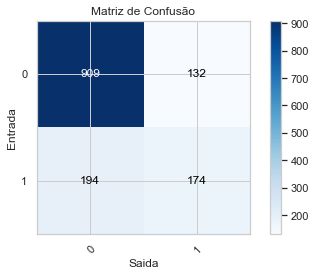

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1041
           1       0.57      0.47      0.52       368

    accuracy                           0.77      1409
   macro avg       0.70      0.67      0.68      1409
weighted avg       0.76      0.77      0.76      1409

Precisão do modelo: 76.863 %

--- Validação Cruzada ---
Acurácia: 0.76582 (+/- 0.05089)
Tempo decorrido (resultados): 0.40 segundos




--------------- Classificador MLP, solver adam ---------------

Tempo decorrido (treino): 3.73 segundos
Score:  0.7799858055358411
Matriz de Confusão NÃO normalizada


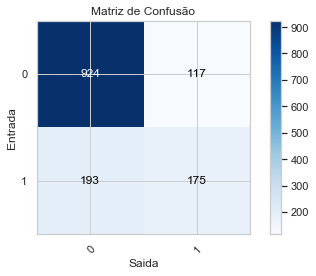

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1041
           1       0.60      0.48      0.53       368

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409

Precisão do modelo: 77.999 %

--- Validação Cruzada ---
Acurácia: 0.76864 (+/- 0.04796)
Tempo decorrido: 8.25 segundos




--------------- Classificador KNeighbors ---------------

Tempo decorrido: 0.01 segundos
Score:  0.7707594038325053
Matriz de Confusão NÃO normalizada


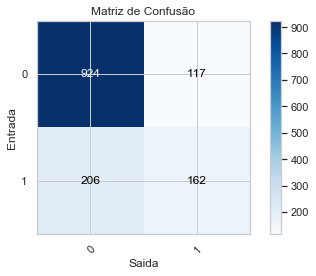

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1041
           1       0.58      0.44      0.50       368

    accuracy                           0.77      1409
   macro avg       0.70      0.66      0.68      1409
weighted avg       0.76      0.77      0.76      1409

Precisão do modelo: 77.076 %

--- Validação Cruzada ---
Acurácia: 0.75796 (+/- 0.04058)
Tempo decorrido: 0.48 segundos


In [33]:
data = df_convertido2[['valor-mensal', 'has-pagamento-online', 'tempo-contrato-meses', 
            'has-parceiro', 'is-idoso']]
labels = df_convertido2['Churn'].values
classes = np.unique(labels)
executar(data, labels, classes, test_size=0.2)

Test size: 0.2
Quantidade de dados para treino: 5634
Quantidade de dados para teste: 1409

--------------- Classificador SVM, kernel linear ---------------

Tempo decorrido (treino): 0.82 segundos
Score:  0.7955997161107168
Matriz de Confusão NÃO normalizada


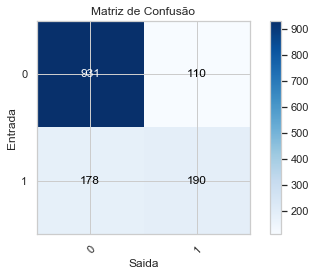

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1041
           1       0.63      0.52      0.57       368

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Precisão do modelo: 79.560 %

--- Validação Cruzada ---
Acurácia: 0.79703 (+/- 0.03335)
Tempo decorrido (resultados): 0.61 segundos




--------------- Classificador MLP, solver adam ---------------

Tempo decorrido (treino): 8.48 segundos
Score:  0.7856635911994322
Matriz de Confusão NÃO normalizada


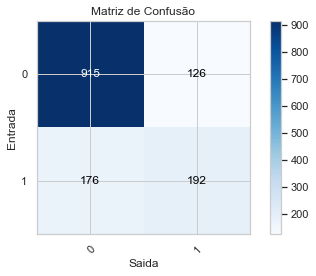

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1041
           1       0.60      0.52      0.56       368

    accuracy                           0.79      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

Precisão do modelo: 78.566 %

--- Validação Cruzada ---
Acurácia: 0.78354 (+/- 0.02322)
Tempo decorrido: 8.93 segundos




--------------- Classificador KNeighbors ---------------

Tempo decorrido: 0.02 segundos
Score:  0.751596877217885
Matriz de Confusão NÃO normalizada


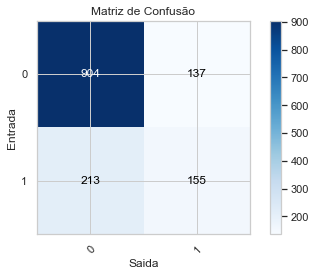

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1041
           1       0.53      0.42      0.47       368

    accuracy                           0.75      1409
   macro avg       0.67      0.64      0.65      1409
weighted avg       0.74      0.75      0.74      1409

Precisão do modelo: 75.160 %

--- Validação Cruzada ---
Acurácia: 0.76580 (+/- 0.03648)
Tempo decorrido: 0.54 segundos


In [34]:
data = df_convertido2[['is-idoso', 'has-parceiro', 'has-dependentes', 
                       'tempo-contrato-meses', 'has-seguranca-online', 
                       'has-suporte-tecnico', 'has-pagamento-online', 
                       'valor-mensal', 'metodo-pagamento']]
executar(data, labels, classes, test_size=0.2)

Os algoritmos SVM com kernel linear, MLP com o solver adam, e KNeighbors foram utilizados para construir modelos capazes de prever se um usuário é potencial candidato a cancelar o contrato ou não. O conjunto de dados foi separado em conjuntos de teste e conjuntos de treino, sendo que 20% foram utilizados para os testes e 80% para os treinamentos.

São mostrados resultados de métricas como a validação cruzada, precisão e revocação, por exemplo. O melhor algoritmo, em termos de validação cruzada, foi o SVM com kernel linear, com uma acurácia de 0.79703 (+/- 0.03335), considerando-se o conjunto de atributos <b>is-idoso, has-parceiro, has-dependentes, tempo-contrato-meses, has-seguranca-online, has-suporte-tecnico, has-pagamento-online, valor-mensal</b> e <b>metodo-pagamento</b>. Este conjunto foi obtido considerando-se a matriz de correlação de Pearson elaborada na questão 1.

Ainda, SVM também apresentou melhores valores de precisão e revocação. O algoritmo KNeighbors foi o mais rápido para executar dentre todos os demais e o algoritmo MLP foi o mais demorado de todos.

<h2>4) Utilizando aprendizado não-supervisionado, crie um modelo para separar os usuários
em dois grupos (sem utilizar o atributo Churn). O objetivo é verificar se é possível utilizar esses
agrupamentos para separar bem os usuários que irão cancelar o contrato ou não. Verifique a
qualidade do agrupamento, e se foi possível ver semelhanças entre os grupos criados e os grupos
reais de Churn=1 e Churn=0.</h2>

In [28]:
#Gerar todas as combinações possíveis para analisar o
#comportamento dos modelo

def get_combinations(values):
    comb=[]    
    for i in range(2, len(values)+1):
        comb_with_i_values = [list(v) for v in itertools.combinations(values, i)]
        comb.extend(comb_with_i_values)        
    return comb

def print_labels(model, df, labels):
    plt.figure(figsize=(10,3))
    
    #Real
    plt.subplot(1,2,1)
    sns.scatterplot(x=df['tempo-contrato-meses'], y=df['valor-mensal'], hue=labels, s=40)
    plt.title('Classificação Real')

    #K-Means
    plt.subplot(1,2,2)
    sns.scatterplot(x=df['tempo-contrato-meses'], y=df['valor-mensal'], hue=model.labels_, s=40)
    plt.title('Classificação K-Means') 
    
    plt.show()

In [29]:
df_convertido3 = df_convertido2.copy()
df_convertido3 = df_convertido3.drop('id-usuario', axis=1)
df_convertido3 = df_convertido3.dropna()

Para analisar diferentes agrupamentos para realizar a separação proposta, vamos analisar os atributos que possuem correlações significativas e interessantes para com o atributo Churn para analisarmos as diferentes combinações entre eles. O algoritmo KMeans foi utilizado.

Features: valor-mensal, has-pagamento-online
Gráficos


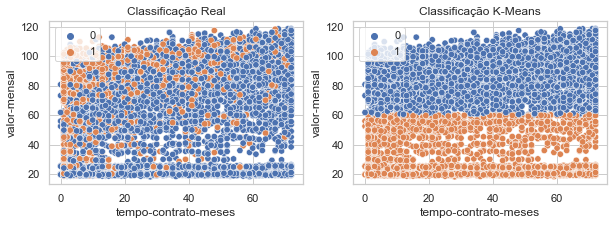

              precision    recall  f1-score   support

           0       0.67      0.53      0.59      5174
           1       0.17      0.27      0.21      1869

    accuracy                           0.46      7043
   macro avg       0.42      0.40      0.40      7043
weighted avg       0.53      0.46      0.49      7043

Silhueta: 0.3813 


Features: valor-mensal, tempo-contrato-meses
Gráficos


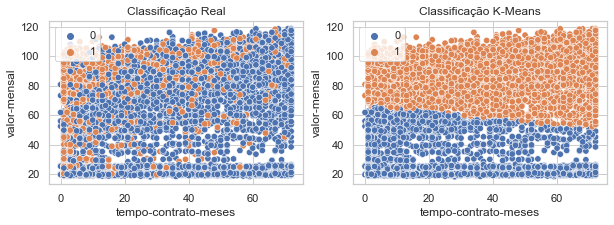

              precision    recall  f1-score   support

           0       0.83      0.46      0.59      5174
           1       0.33      0.73      0.45      1869

    accuracy                           0.53      7043
   macro avg       0.58      0.60      0.52      7043
weighted avg       0.69      0.53      0.55      7043

Silhueta: 0.386 


Features: valor-mensal, has-parceiro
Gráficos


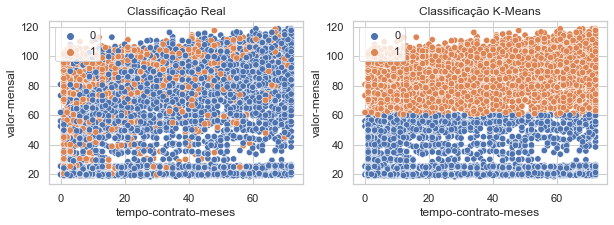

              precision    recall  f1-score   support

           0       0.83      0.47      0.60      5174
           1       0.33      0.73      0.46      1869

    accuracy                           0.54      7043
   macro avg       0.58      0.60      0.53      7043
weighted avg       0.70      0.54      0.56      7043

Silhueta: 0.3813 


Features: valor-mensal, is-idoso
Gráficos


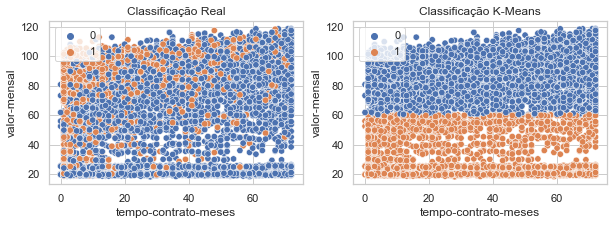

              precision    recall  f1-score   support

           0       0.67      0.53      0.59      5174
           1       0.17      0.27      0.21      1869

    accuracy                           0.46      7043
   macro avg       0.42      0.40      0.40      7043
weighted avg       0.53      0.46      0.49      7043

Silhueta: 0.3813 


Features: has-pagamento-online, tempo-contrato-meses
Gráficos


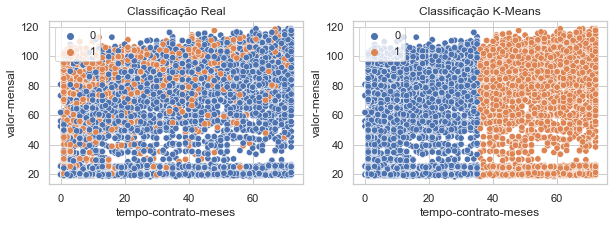

              precision    recall  f1-score   support

           0       0.62      0.48      0.54      5174
           1       0.12      0.20      0.15      1869

    accuracy                           0.41      7043
   macro avg       0.37      0.34      0.35      7043
weighted avg       0.49      0.41      0.44      7043

Silhueta: 0.2853 


Features: has-pagamento-online, has-parceiro
Gráficos


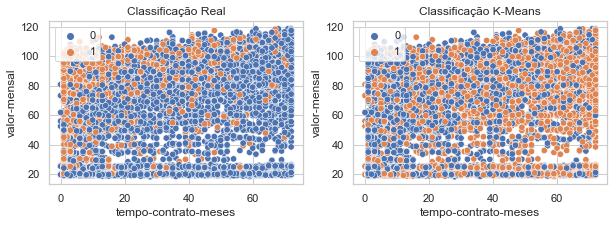

              precision    recall  f1-score   support

           0       0.67      0.47      0.55      5174
           1       0.20      0.36      0.25      1869

    accuracy                           0.44      7043
   macro avg       0.43      0.41      0.40      7043
weighted avg       0.54      0.44      0.47      7043

Silhueta: 0.0571 


Features: has-pagamento-online, is-idoso
Gráficos


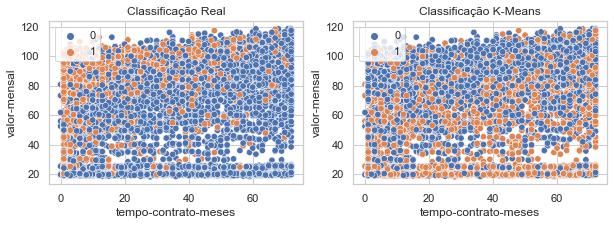

              precision    recall  f1-score   support

           0       0.66      0.54      0.59      5174
           1       0.16      0.25      0.20      1869

    accuracy                           0.46      7043
   macro avg       0.41      0.39      0.40      7043
weighted avg       0.53      0.46      0.49      7043

Silhueta: 0.0693 


Features: tempo-contrato-meses, has-parceiro
Gráficos


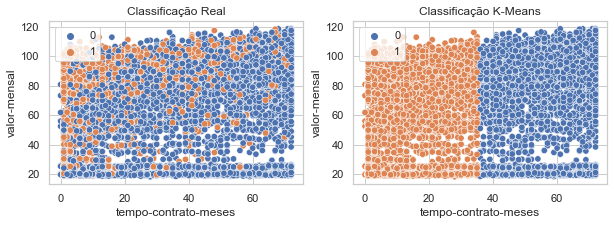

              precision    recall  f1-score   support

           0       0.88      0.52      0.65      5174
           1       0.38      0.80      0.51      1869

    accuracy                           0.59      7043
   macro avg       0.63      0.66      0.58      7043
weighted avg       0.75      0.59      0.62      7043

Silhueta: 0.2853 


Features: tempo-contrato-meses, is-idoso
Gráficos


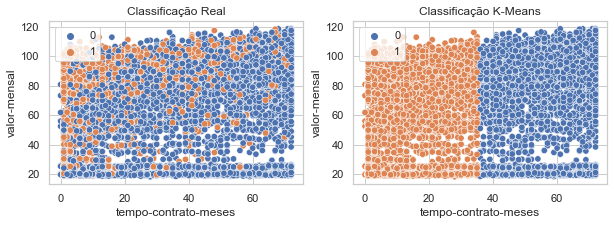

              precision    recall  f1-score   support

           0       0.88      0.52      0.65      5174
           1       0.38      0.80      0.51      1869

    accuracy                           0.59      7043
   macro avg       0.63      0.66      0.58      7043
weighted avg       0.75      0.59      0.62      7043

Silhueta: 0.2853 


Features: has-parceiro, is-idoso
Gráficos


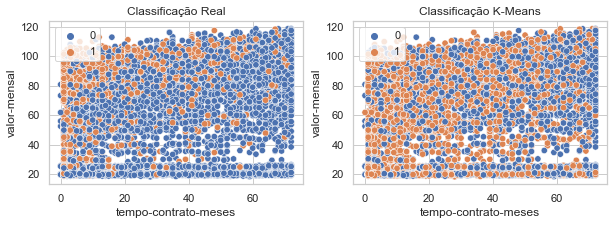

              precision    recall  f1-score   support

           0       0.80      0.53      0.64      5174
           1       0.33      0.64      0.44      1869

    accuracy                           0.56      7043
   macro avg       0.57      0.59      0.54      7043
weighted avg       0.68      0.56      0.58      7043

Silhueta: 0.0571 


Features: valor-mensal, has-pagamento-online, tempo-contrato-meses
Gráficos


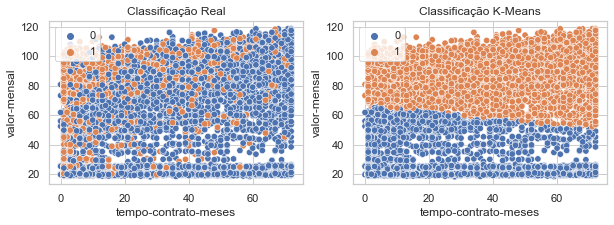

              precision    recall  f1-score   support

           0       0.83      0.46      0.59      5174
           1       0.33      0.73      0.45      1869

    accuracy                           0.53      7043
   macro avg       0.58      0.60      0.52      7043
weighted avg       0.69      0.53      0.55      7043

Silhueta: 0.386 


Features: valor-mensal, has-pagamento-online, has-parceiro
Gráficos


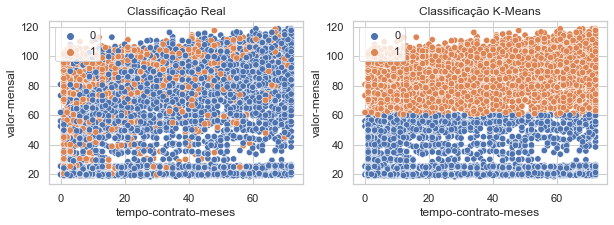

              precision    recall  f1-score   support

           0       0.83      0.47      0.60      5174
           1       0.33      0.73      0.46      1869

    accuracy                           0.54      7043
   macro avg       0.58      0.60      0.53      7043
weighted avg       0.70      0.54      0.56      7043

Silhueta: 0.3813 


Features: valor-mensal, has-pagamento-online, is-idoso
Gráficos


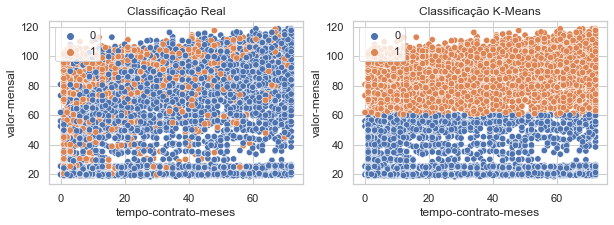

              precision    recall  f1-score   support

           0       0.83      0.47      0.60      5174
           1       0.33      0.73      0.46      1869

    accuracy                           0.54      7043
   macro avg       0.58      0.60      0.53      7043
weighted avg       0.70      0.54      0.56      7043

Silhueta: 0.3813 


Features: valor-mensal, tempo-contrato-meses, has-parceiro
Gráficos


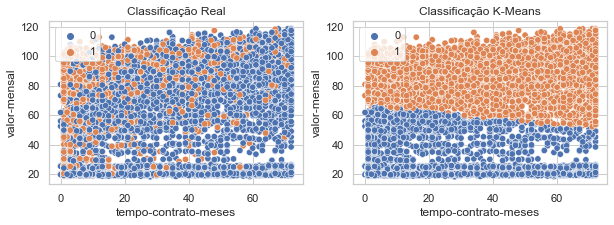

              precision    recall  f1-score   support

           0       0.83      0.46      0.59      5174
           1       0.33      0.73      0.45      1869

    accuracy                           0.53      7043
   macro avg       0.58      0.60      0.52      7043
weighted avg       0.69      0.53      0.55      7043

Silhueta: 0.386 


Features: valor-mensal, tempo-contrato-meses, is-idoso
Gráficos


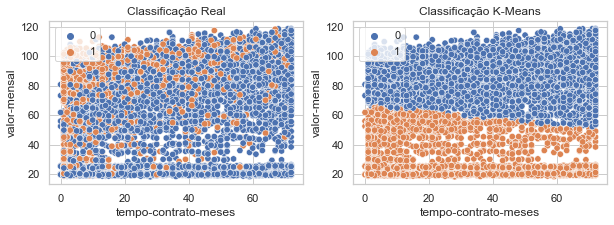

              precision    recall  f1-score   support

           0       0.67      0.54      0.60      5174
           1       0.17      0.27      0.21      1869

    accuracy                           0.47      7043
   macro avg       0.42      0.40      0.40      7043
weighted avg       0.54      0.47      0.50      7043

Silhueta: 0.386 


Features: valor-mensal, has-parceiro, is-idoso
Gráficos


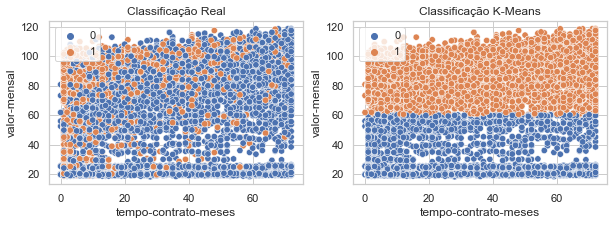

              precision    recall  f1-score   support

           0       0.83      0.47      0.60      5174
           1       0.33      0.73      0.46      1869

    accuracy                           0.54      7043
   macro avg       0.58      0.60      0.53      7043
weighted avg       0.70      0.54      0.56      7043

Silhueta: 0.3814 


Features: has-pagamento-online, tempo-contrato-meses, has-parceiro
Gráficos


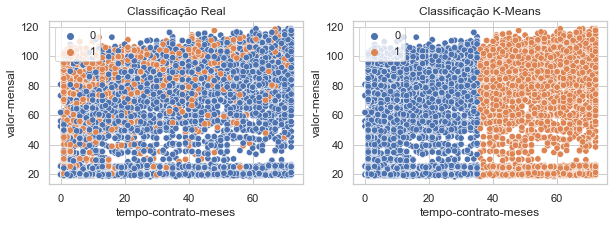

              precision    recall  f1-score   support

           0       0.62      0.48      0.54      5174
           1       0.12      0.20      0.15      1869

    accuracy                           0.41      7043
   macro avg       0.37      0.34      0.35      7043
weighted avg       0.49      0.41      0.44      7043

Silhueta: 0.2853 


Features: has-pagamento-online, tempo-contrato-meses, is-idoso
Gráficos


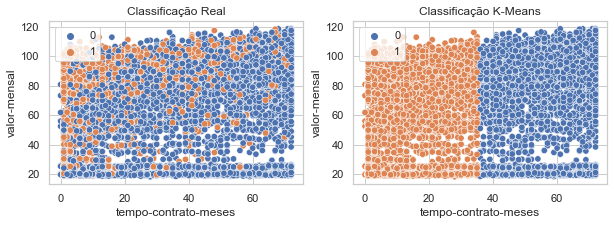

              precision    recall  f1-score   support

           0       0.88      0.52      0.65      5174
           1       0.38      0.80      0.51      1869

    accuracy                           0.59      7043
   macro avg       0.63      0.66      0.58      7043
weighted avg       0.75      0.59      0.62      7043

Silhueta: 0.2853 


Features: has-pagamento-online, has-parceiro, is-idoso
Gráficos


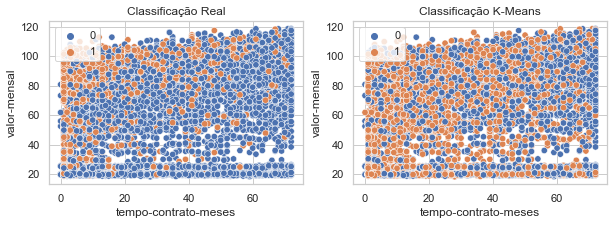

              precision    recall  f1-score   support

           0       0.80      0.53      0.64      5174
           1       0.33      0.64      0.44      1869

    accuracy                           0.56      7043
   macro avg       0.57      0.59      0.54      7043
weighted avg       0.68      0.56      0.58      7043

Silhueta: 0.0571 


Features: tempo-contrato-meses, has-parceiro, is-idoso
Gráficos


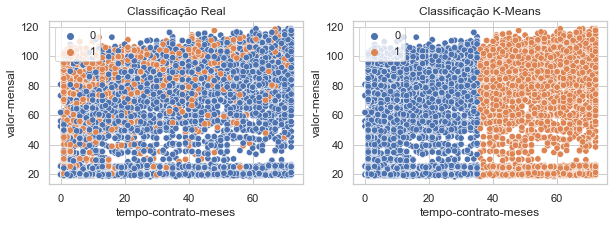

              precision    recall  f1-score   support

           0       0.62      0.48      0.54      5174
           1       0.12      0.20      0.15      1869

    accuracy                           0.41      7043
   macro avg       0.37      0.34      0.35      7043
weighted avg       0.49      0.41      0.44      7043

Silhueta: 0.2853 


Features: valor-mensal, has-pagamento-online, tempo-contrato-meses, has-parceiro
Gráficos


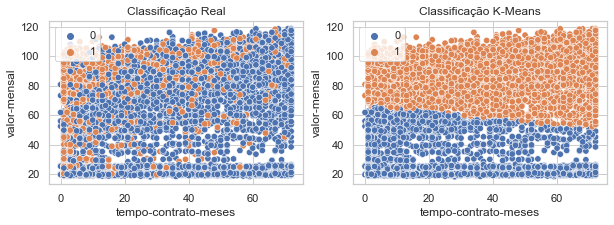

              precision    recall  f1-score   support

           0       0.83      0.46      0.59      5174
           1       0.33      0.73      0.45      1869

    accuracy                           0.53      7043
   macro avg       0.58      0.60      0.52      7043
weighted avg       0.69      0.53      0.55      7043

Silhueta: 0.386 


Features: valor-mensal, has-pagamento-online, tempo-contrato-meses, is-idoso
Gráficos


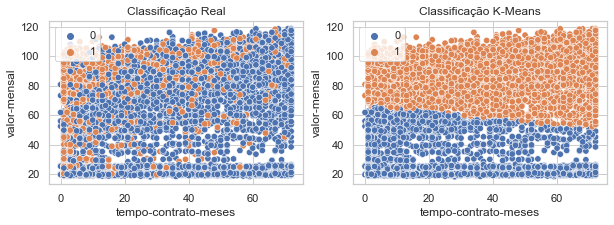

              precision    recall  f1-score   support

           0       0.83      0.46      0.59      5174
           1       0.33      0.73      0.45      1869

    accuracy                           0.53      7043
   macro avg       0.58      0.60      0.52      7043
weighted avg       0.69      0.53      0.55      7043

Silhueta: 0.386 


Features: valor-mensal, has-pagamento-online, has-parceiro, is-idoso
Gráficos


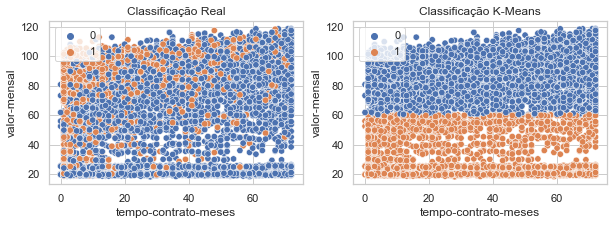

              precision    recall  f1-score   support

           0       0.67      0.53      0.59      5174
           1       0.17      0.27      0.21      1869

    accuracy                           0.46      7043
   macro avg       0.42      0.40      0.40      7043
weighted avg       0.53      0.46      0.49      7043

Silhueta: 0.3813 


Features: valor-mensal, tempo-contrato-meses, has-parceiro, is-idoso
Gráficos


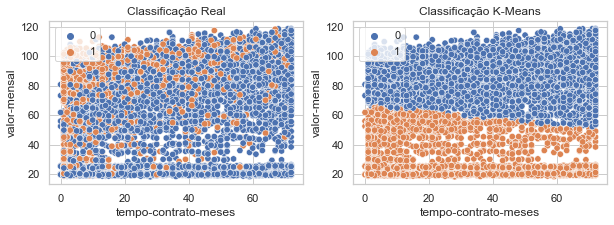

              precision    recall  f1-score   support

           0       0.67      0.54      0.60      5174
           1       0.17      0.27      0.21      1869

    accuracy                           0.47      7043
   macro avg       0.42      0.40      0.40      7043
weighted avg       0.54      0.47      0.50      7043

Silhueta: 0.386 


Features: has-pagamento-online, tempo-contrato-meses, has-parceiro, is-idoso
Gráficos


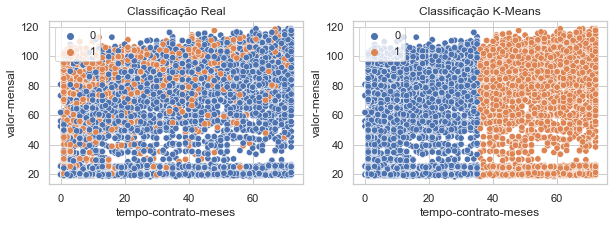

              precision    recall  f1-score   support

           0       0.62      0.48      0.54      5174
           1       0.12      0.20      0.15      1869

    accuracy                           0.41      7043
   macro avg       0.37      0.34      0.35      7043
weighted avg       0.49      0.41      0.44      7043

Silhueta: 0.2853 


Features: valor-mensal, has-pagamento-online, tempo-contrato-meses, has-parceiro, is-idoso
Gráficos


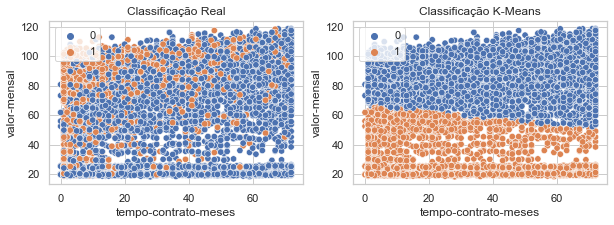

              precision    recall  f1-score   support

           0       0.67      0.54      0.60      5174
           1       0.17      0.27      0.21      1869

    accuracy                           0.47      7043
   macro avg       0.42      0.40      0.40      7043
weighted avg       0.54      0.47      0.50      7043

Silhueta: 0.386 




In [30]:
melhores_features = ''
melhor_silhueta = -9999
conjunto = ['valor-mensal', 'has-pagamento-online', 'tempo-contrato-meses', 
            'has-parceiro', 'is-idoso']
#['valor-mensal', 'has-pagamento-online', 
                                  #'tempo-contrato-meses', 'is-idoso', 'metodo-pagamento']
for features in get_combinations(conjunto):
    print('Features: ', end='')
    print(*features, sep=', ')
    
    kmeans = KMeans(n_clusters=2).fit(df_convertido3[features])
    print('Gráficos')
    print_labels(kmeans, df_convertido3, labels)
    y_pred = pd.Series(kmeans.labels_)    
    print(classification_report(labels, y_pred))
    silhueta = metrics.silhouette_score(df_convertido3, kmeans.labels_)
    print('Silhueta:', round(silhueta, 4), '\n\n')
    if(silhueta > melhor_silhueta):
        melhores_features = features
        melhor_silhueta = silhueta    

In [31]:
print('Melhor silhueta: %.4f' % melhor_silhueta)
print('Melhores atributos:', melhores_features)

Melhor silhueta: 0.3860
Melhores atributos: ['valor-mensal', 'tempo-contrato-meses']


Features: valor-mensal, tempo-contrato-meses
Gráficos


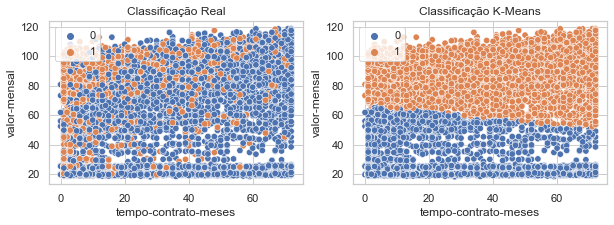

              precision    recall  f1-score   support

           0       0.83      0.46      0.59      5174
           1       0.33      0.73      0.45      1869

    accuracy                           0.53      7043
   macro avg       0.58      0.60      0.52      7043
weighted avg       0.69      0.53      0.55      7043

Silhueta: 0.386 




In [32]:
features = melhores_features
print('Features: ', end='')
print(*features, sep=', ')

kmeans = KMeans(n_clusters=2).fit(df_convertido3[features])
print('Gráficos')
print_labels(kmeans, df_convertido3, labels)
y_pred = pd.Series(kmeans.labels_)    
print(classification_report(labels, y_pred))
silhueta = metrics.silhouette_score(df_convertido3, kmeans.labels_)
print('Silhueta:', round(silhueta, 4), '\n\n')

Observando-se os gráficos acima e as respetivas informações para avaliar a qualidade dos agrupamentos, o melhor conjunto de atributos possui <b>0.386</b> de valor de <b>silhueta</b> e corresponde ao conjunto composto pelos atributos <b>valor-mensal</b> e <b>tempo-contrato-meses</b>. 

Dando destaque para a essa combinação, pode-se visualizar na imagem acima que o agrupamento conseguiu fazer uma separação que visualmente é boa, porém, note que o valor da silhueta é mais próximo de <b>zero</b> do que <b>um</b>, indicando que há um grau de sobreposição dos clusteres considerável. Note, inclusive, os valores de precisão, comprovando que essa separação pelo KMeans não foi tão efetiva quanto visualmente parece.